In [21]:
# Step 1: Install the necessary library
# !pip install fiftyone

import fiftyone as fo
import fiftyone.zoo as foz

# Step 2: Download a subset of Open Images V7
# We'll load 500 samples from the 'validation' split that have 'detections' for the 'Fish' class.
dataset = foz.load_zoo_dataset(
    "open-images-v7",
    split="validation",           # Can also use "train" or "test"
    label_types=["detections"],   # We need bounding boxes
    classes=["Fish"],             # Filter for your target class
    max_samples=5000,              # Limit size for manageability
    # dataset_dir="open_images_fish", # Directory to save data
    shuffle=True
)


Only found 356 (<5000) samples matching your requirements
Necessary images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'open-images-v7-validation-5000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


MEMULAI PROSES PREPARASI DATASET IKAN

📥 Mengunduh dan memuat dataset Open Images V7 (hanya kelas 'Fish')...
Only found 356 (<5000) samples matching your requirements
Necessary images already downloaded
Existing download of split 'validation' is sufficient
Loading 'open-images-v7' split 'validation'
 100% |█████████████████| 356/356 [1.3s elapsed, 0s remaining, 270.4 samples/s]         
Dataset 'fish-detection-dataset' created
✅ Dataset 'fish-detection-dataset' berhasil dimuat!
   📊 Jumlah sampel: 356

DIAGNOSIS STRUKTUR DATASET
🔍 Field yang tersedia pada sampel pertama:
   - 'id': str
   - 'filepath': str
   - 'tags': BaseList
   - 'metadata': NoneType
   - 'created_at': datetime
   - 'last_modified_at': datetime
   - 'ground_truth': Detections
      Tipe: <class 'fiftyone.core.labels.Detections'>

🔎 Mencari field yang berisi deteksi...
   Field 'ground_truth': <class 'fiftyone.core.labels.Detections'>
      ✅ Ditemukan 12 deteksi!
      Contoh: Label='Fish'

PROSES CROPPING GAMBAR IK

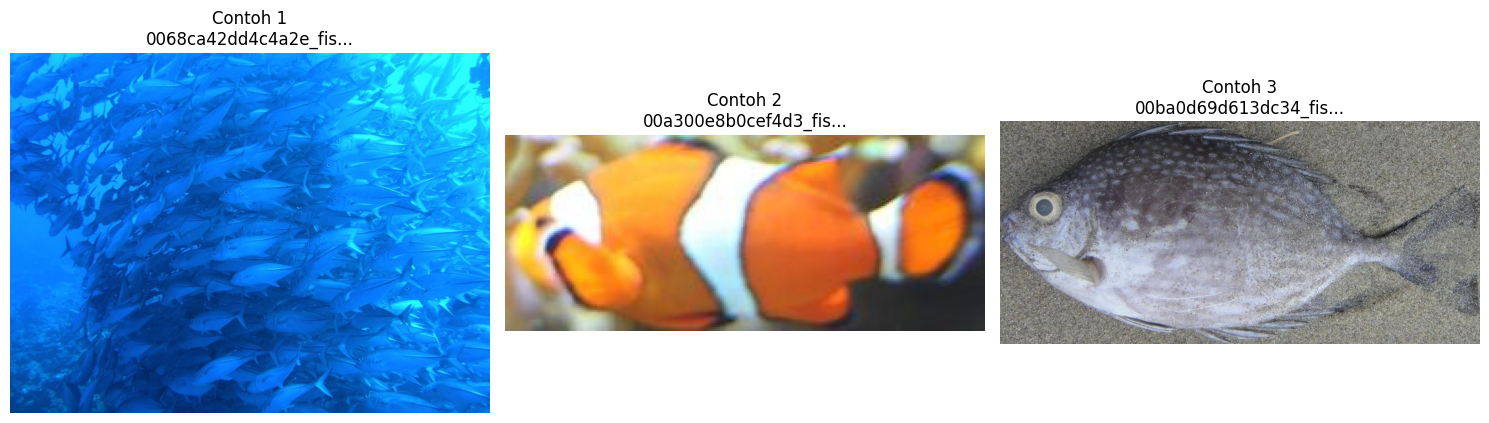


PROSES SELESAI

💾 Informasi dataset disimpan di: ./fish_crops\dataset_info.txt


In [22]:
import os
from PIL import Image
import numpy as np
import fiftyone as fo
import fiftyone.zoo as foz
import pandas as pd

print("=" * 70)
print("MEMULAI PROSES PREPARASI DATASET IKAN")
print("=" * 70)

# ---- BAGIAN 1: HAPUS DAN MUAT ULANG DATASET DENGAN KONFIGURASI TEPAT ----
dataset_name = "fish-detection-dataset"

# Hapus dataset lama jika ada
if dataset_name in fo.list_datasets():
    print(f"🗑️  Menghapus dataset lama '{dataset_name}'...")
    fo.delete_dataset(dataset_name)

print("\n📥 Mengunduh dan memuat dataset Open Images V7 (hanya kelas 'Fish')...")

# Muat dataset dengan konfigurasi yang lebih eksplisit
dataset = foz.load_zoo_dataset(
    "open-images-v7",
    split="validation",
    label_types=["detections"],
    classes=["Fish"],
    max_samples=5000,
    shuffle=True,
    dataset_name=dataset_name,
    only_matching=True,  # Hanya menyertakan gambar yang memiliki deteksi 'Fish'
    seed=42
)

print(f"✅ Dataset '{dataset.name}' berhasil dimuat!")
print(f"   📊 Jumlah sampel: {len(dataset)}")

# ---- BAGIAN 2: DIAGNOSIS STRUKTUR DATASET ----
print("\n" + "=" * 70)
print("DIAGNOSIS STRUKTUR DATASET")
print("=" * 70)

if len(dataset) > 0:
    sample = dataset.first()
    
    print("🔍 Field yang tersedia pada sampel pertama:")
    for field_name in sample.field_names:
        field_value = sample[field_name]
        print(f"   - '{field_name}': {type(field_value).__name__}")
        
        # Tampilkan detail untuk field yang penting
        if field_name == "detections" and field_value is not None:
            print(f"      Jumlah deteksi: {len(field_value.detections)}")
            for i, det in enumerate(field_value.detections[:3]):  # Tampilkan 3 pertama
                print(f"      Deteksi {i+1}: Label='{det.label}', BBox={det.bounding_box}")
        elif field_name == "ground_truth" and field_value is not None:
            print(f"      Tipe: {type(field_value)}")
    
    # Cek apakah ada deteksi dengan cara lain
    print("\n🔎 Mencari field yang berisi deteksi...")
    
    # Coba cari field yang mungkin berisi deteksi
    possible_detection_fields = ["detections", "ground_truth", "objects", "labels"]
    found_detections = False
    
    for field in possible_detection_fields:
        if field in sample.field_names:
            field_value = sample[field]
            print(f"   Field '{field}': {type(field_value)}")
            
            # Coba akses deteksi
            try:
                if hasattr(field_value, 'detections'):
                    detections = field_value.detections
                    if len(detections) > 0:
                        print(f"      ✅ Ditemukan {len(detections)} deteksi!")
                        print(f"      Contoh: Label='{detections[0].label}'")
                        found_detections = True
                        break
            except:
                pass
    
    if not found_detections:
        print("   ⚠️  Tidak ditemukan field deteksi yang dapat diakses.")
        print("   ℹ️  Akan mencoba pendekatan alternatif...")

# ---- BAGIAN 3: PROSES CROPPING DENGAN PENANGANAN MULTI-SKENARIO ----
print("\n" + "=" * 70)
print("PROSES CROPPING GAMBAR IKAN")
print("=" * 70)

# 1. Siapkan struktur folder
base_crop_dir = "./fish_crops"
train_dir = os.path.join(base_crop_dir, "train")
val_dir = os.path.join(base_crop_dir, "val")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# 2. Parameter
split_ratio = 0.8
np.random.seed(42)
image_count = 0
problem_count = 0

print(f"🎯 Target folder: {base_crop_dir}")
print(f"📁 Train: {train_dir}")
print(f"📁 Val: {val_dir}")

# 3. Fungsi untuk mendapatkan deteksi dari sampel
def get_detections_from_sample(sample):
    """Mencoba berbagai cara untuk mendapatkan deteksi dari sampel."""
    
    # Coba field 'detections' langsung
    if "detections" in sample.field_names:
        detections_field = sample["detections"]
        if detections_field is not None and hasattr(detections_field, 'detections'):
            return detections_field.detections
    
    # Coba field 'ground_truth'
    if "ground_truth" in sample.field_names:
        gt_field = sample["ground_truth"]
        if gt_field is not None and hasattr(gt_field, 'detections'):
            return gt_field.detections
    
    # Coba field lain yang mungkin
    for field_name in sample.field_names:
        field_value = sample[field_name]
        if field_value is not None and hasattr(field_value, 'detections'):
            return field_value.detections
    
    return None

# 4. Proses cropping
print("\n⏳ Memulai proses cropping...")

for idx, sample in enumerate(dataset):
    # Progress update
    if idx % 50 == 0 and idx > 0:
        print(f"   📊 Progress: {idx}/{len(dataset)} gambar, {image_count} ikan berhasil dicrop")
    
    try:
        # Buka gambar
        img_path = sample.filepath
        if not os.path.exists(img_path):
            problem_count += 1
            continue
        
        img = Image.open(img_path).convert("RGB")
        img_width, img_height = img.size
        
        # Dapatkan deteksi
        detections = get_detections_from_sample(sample)
        
        if detections is None or len(detections) == 0:
            # Gambar ini tidak memiliki deteksi ikan
            continue
        
        # Proses setiap deteksi
        for detection in detections:
            # Pastikan ini deteksi ikan
            if hasattr(detection, 'label') and detection.label == "Fish":
                # Dapatkan bounding box
                if not hasattr(detection, 'bounding_box'):
                    continue
                
                bbox = detection.bounding_box
                if len(bbox) != 4:
                    continue
                
                # Konversi ke koordinat pixel
                x_min_norm, y_min_norm, width_norm, height_norm = bbox
                x_min = int(x_min_norm * img_width)
                y_min = int(y_min_norm * img_height)
                x_max = int((x_min_norm + width_norm) * img_width)
                y_max = int((y_min_norm + height_norm) * img_height)
                
                # Validasi ukuran bounding box
                if (x_max - x_min) < 20 or (y_max - y_min) < 20:
                    continue
                
                # Pastikan dalam batas gambar
                x_min = max(0, x_min)
                y_min = max(0, y_min)
                x_max = min(img_width, x_max)
                y_max = min(img_height, y_max)
                
                if x_min >= x_max or y_min >= y_max:
                    continue
                
                # Crop gambar
                try:
                    cropped_img = img.crop((x_min, y_min, x_max, y_max))
                    
                    # Tentukan folder penyimpanan
                    save_dir = train_dir if np.random.random() < split_ratio else val_dir
                    
                    # Buat nama file
                    base_name = os.path.basename(img_path).split('.')[0]
                    filename = f"{base_name}_fish_{image_count:06d}.jpg"
                    save_path = os.path.join(save_dir, filename)
                    
                    # Simpan gambar
                    cropped_img.save(save_path)
                    image_count += 1
                    
                except Exception as crop_error:
                    problem_count += 1
                    if problem_count <= 3:
                        print(f"    ⚠️  Gagal crop: {str(crop_error)[:50]}...")
    
    except Exception as e:
        problem_count += 1
        if problem_count <= 5:
            print(f"    ⚠️  Error memproses {os.path.basename(sample.filepath)}: {str(e)[:50]}...")

# ---- BAGIAN 4: HASIL DAN VERIFIKASI ----
print("\n" + "=" * 70)
print("HASIL PROSES CROPPING")
print("=" * 70)

print(f"\n📊 STATISTIK:")
print(f"   ✅ Gambar ikan berhasil dicrop: {image_count}")
print(f"   ⚠️  Masalah yang ditemui: {problem_count}")
print(f"   📁 Folder train: {train_dir} ({len(os.listdir(train_dir))} file)")
print(f"   📁 Folder val: {val_dir} ({len(os.listdir(val_dir))} file)")

# Verifikasi dengan menampilkan beberapa hasil
print("\n🔍 VERIFIKASI VISUAL:")

# Cek apakah ada file yang berhasil disimpan
all_files = []
for folder in [train_dir, val_dir]:
    if os.path.exists(folder):
        files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        all_files.extend([(folder, f) for f in files])

if len(all_files) > 0:
    print(f"   Ditemukan {len(all_files)} file gambar.")
    
    # Tampilkan 3 gambar pertama
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, min(3, len(all_files)), figsize=(15, 5))
    
    if min(3, len(all_files)) == 1:
        axes = [axes]
    
    for i, (folder, filename) in enumerate(all_files[:3]):
        try:
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)
            
            axes[i].imshow(img)
            axes[i].set_title(f"Contoh {i+1}\n{filename[:20]}...")
            axes[i].axis('off')
            img.close()
            
            # Tampilkan info ukuran
            print(f"   Contoh {i+1}: {filename} ({img.size[0]}x{img.size[1]} px)")
        except Exception as e:
            axes[i].text(0.5, 0.5, "Gagal\nmemuat", ha='center', va='center')
            axes[i].set_title(f"Contoh {i+1}\n(Error)")
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("   ⚠️  Tidak ada file gambar yang ditemukan.")
    
    # Diagnosa lebih lanjut
    print("\n🔧 DIAGNOSA LANJUT:")
    print("   Kemungkinan masalah:")
    print("   1. Dataset tidak memiliki deteksi 'Fish'")
    print("   2. Field deteksi tidak dapat diakses")
    print("   3. Bounding box tidak valid")
    
    # Coba analisis deteksi
    if len(dataset) > 0:
        sample = dataset.first()
        print(f"\n   Contoh sampel pertama:")
        print(f"   - Path: {sample.filepath}")
        
        # Hitung total deteksi di seluruh dataset
        total_detections = 0
        fish_detections = 0
        
        for i, samp in enumerate(dataset):
            dets = get_detections_from_sample(samp)
            if dets:
                total_detections += len(dets)
                for det in dets:
                    if hasattr(det, 'label') and det.label == "Fish":
                        fish_detections += 1
            
            if i >= 10:  # Cek 10 sampel pertama saja
                break
        
        print(f"   - Deteksi total (10 sampel pertama): {total_detections}")
        print(f"   - Deteksi 'Fish' (10 sampel pertama): {fish_detections}")

print("\n" + "=" * 70)
print("PROSES SELESAI")
print("=" * 70)

# Simpan informasi dataset ke file
if image_count > 0:
    info_file = os.path.join(base_crop_dir, "dataset_info.txt")
    with open(info_file, 'w') as f:
        f.write(f"Dataset Ikan - Open Images V7\n")
        f.write(f"Dibuat pada: {pd.Timestamp.now()}\n")
        f.write(f"Jumlah gambar ikan: {image_count}\n")
        f.write(f"Train: {len(os.listdir(train_dir))} file\n")
        f.write(f"Val: {len(os.listdir(val_dir))} file\n")
    
    print(f"\n💾 Informasi dataset disimpan di: {info_file}")